# Visão computacional para solucionar problema de restrição etária

Uma rede de supermercados necessita impedir a venda de bibidas alcoólicas para menores de idade. Cada área de checkout possui câmeras que são acionadas quando uma pessoa está comprando álcool, então a partir dessas imagens é possível construir e avaliar um modelo para verificar a idade das pessoas. 

Foi utilizado o métodos de visão computacional para detectar a idade de uma pessoa a partir das imagens.

## Inicialização 

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [4]:
# Setando o estilo dos gráficos
sns.set_style("whitegrid", rc={"grid.linestyle": ":"})
sns.color_palette("Paired")

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Carregue os dados

In [4]:
# Armazenando a leitura dos dados em variáveis
df = pd.read_csv('/datasets/faces/labels.csv')
image_directory = '/datasets/faces/final_files/'

In [24]:
images_dir = os.stat(image_directory)
print(f'O tamanho do diretório em Bytes é: {images_dir.st_size}')

O tamanho do diretório em Bytes é: 256000


In [19]:
# Verificando o tamanho do dataset
print("Tamanho do conjunto de dados é: ", len(df))

Tamanho do conjunto de dados é:  7591


In [7]:
# Verificando variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
# Procurando valores ausentes
df.isna().sum()

file_name    0
real_age     0
dtype: int64

In [10]:
# Procurando 
df.duplicated().sum()

0

### Conclusões

* O diretorio de imagens está armazenado na variável <em>'image_directory'</em> e armazenda 256000 Bytes de imagens. 


* O dataset df possui 7591 abservações, é composto por duas colunas: com o nome das imagens no diretório (<em>'file_name'</em>) e a idade real correspondente à pessoa da imagem <em>('real_age')</em>. Não possui valores ausentes e duplicados.

## EDA

In [5]:
# Análise descritiva das idades no conjunto
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
# Analizando dispersão dos dados no conjunto
variancia = np.round(df['real_age'].var())
assimetria = np.round(df['real_age'].skew())
Q1 = df['real_age'].quantile(0.25)
Q3 = df['real_age'].quantile(0.75)
IQR = Q3 - Q1
minimo = Q1 - 1.5 * IQR
maximo = Q3 + 1.5 * IQR


print(f'A variância do conjunto de dados é de: {variancia}\n')
print(f'A assimetria do conjunto de dados é de: {assimetria}\n')
print(f'O Intervalo Interquartil do conjunto de dados é de: {IQR}\n')
print(f'O limite máximo do intervalo interquartil é de: {maximo}\n')
print(f'O limite mínimo do intervalo interquartil é de: {minimo}')

A variância do conjunto de dados é de: 294.0

A assimetria do conjunto de dados é de: 1.0

O Intervalo Interquartil do conjunto de dados é de: 21.0

O limite máximo do intervalo interquartil é de: 72.5

O limite mínimo do intervalo interquartil é de: -11.5


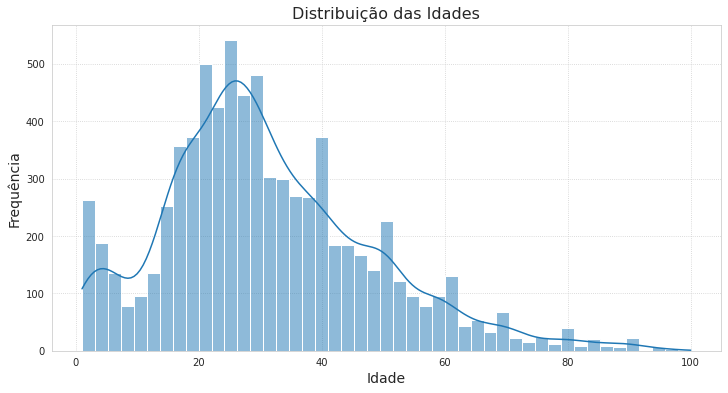

In [7]:
# Histograma
fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(data=df, x='real_age', kde=True)
plt.xlabel('Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Distribuição das Idades', fontsize=16)
plt.show()

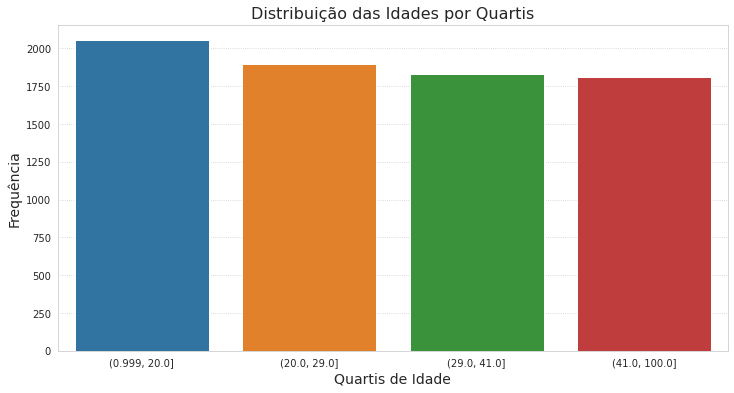

In [8]:
# Separando as idades em quartis e plotando o resultado em gráfico de barras
faixa_etária = pd.qcut(df['real_age'], 4)

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=faixa_etária)
plt.xlabel('Quartis de Idade', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Distribuição das Idades por Quartis', fontsize=16)

plt.show()

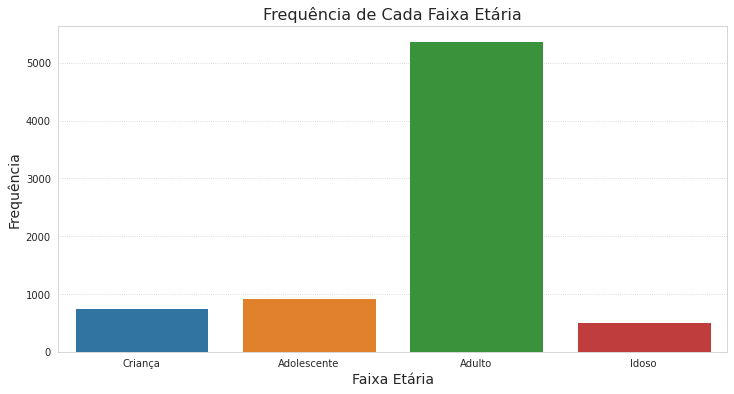

In [9]:
# Verificando a quantidade de observações por faixas etárias (IBGE)
classes = [0, 11, 18, 59, float('inf')] #range de idades de acordo com IBGE
faixa_etaria = ['Criança', 'Adolescente', 'Adulto', 'Idoso'] #classificação que cada range irá receber
classes = pd.cut(x=df['real_age'], bins=classes, labels=faixa_etaria) # separando a coluna pela 
                                                                      #classificação(labels) de acordo 
                                                                      #com os ranges

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=classes)
plt.xlabel('Faixa Etária', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.title('Frequência de Cada Faixa Etária', fontsize=16)
plt.show()

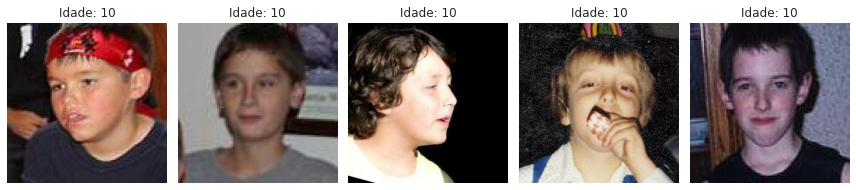

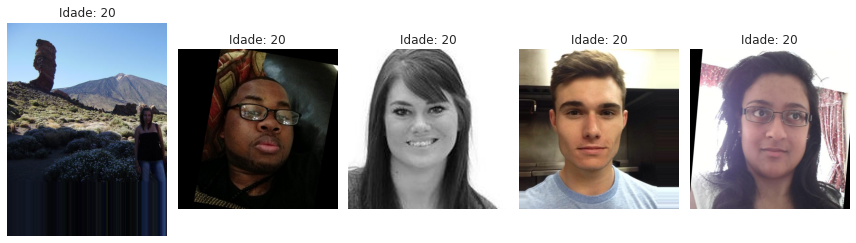

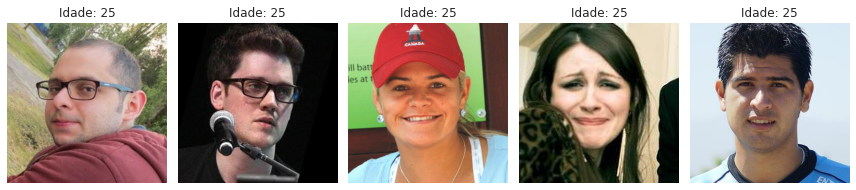

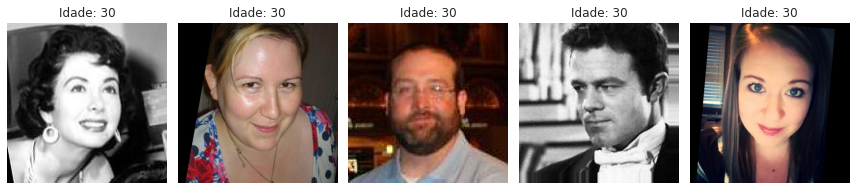

In [10]:
# Passando as idades que serão mostradas 
ages = [10, 20, 25, 30]
# Para cada idade será retornado 5 imagens
num_samples = 5 

for age in ages:
    age_subset = df[df['real_age'] == age] #filtrando a idade real
    file_names = np.array(age_subset['file_name'].head(15))#chamando as fotos do diretório de acordo com a idade e
                                                           #nome do arquivo

# Plotando imagens
    plt.figure(figsize=(12, 6))
    for i, file_name in enumerate(file_names):
        image_path = os.path.join(image_directory, file_name)#unindo o path do diretorio de imagens 
                                                             #pelo nome do arquivo 
        image = Image.open(image_path)#carregando as imagens
        
        # subplots de uma linha, iteração com o num_sample (a cada iteração ele atualiza para o próximo valor 
        # de sample 1, 1+1=2, 2+1=3, etc. O último parâmetro e a legenda de cada subplot
        plt.subplot(1, num_samples, i % num_samples + 1, label='subplot{}'.format(i))
        plt.imshow(image)#imprimindo a imagem
        plt.axis('off')#retirando os eixos, para que apareça só a imagem
        plt.title(f'Idade: {age}')# o título dos subplots com a idade correspondente
    
    plt.tight_layout()
    plt.show()

### Conclusões

1. O conjunto de dados contém 7591 observações. A idade média das pessoas é de 31,40 anos com um desvio padrão de 17,14 anos. A idade mediana é de 29 anos. A idade mínima é de 1 ano e a idade máxima é de 100 anos. 

2. As medidas de dispersão indicam que os valores de idade estão concentrados à direita da média, sugerindo uma distribuição assimétrica à direita com um valor de assimetria positivo (skew=1.0).


3. O histograma representa visualmente a distribuição do conjunto de dados. Há uma concentração maior de pessoas com idades entre 20 e 40 anos, com menor ocorrências de valores extremos de idade.


4. Ao dividir o conjunto de dados em quartis, verifica-se que a maioria das pessoas se encontra na faixa etária de 0 a 20 anos, seguida de 20 a 29 anos. Há uma frequência relativamente similar entre os quartis de 29 a 41 e 41 a 100 anos.


5. Ao separar o conjunto de dados por faixas etárias, observa-se que há uma predominância de adultos.


6. A distribuição dos dados pode introduzir ao viés de treinamento, onde o modelo pode ter maior precisão ao prever adultos em comparação com crianças e idosos. Isso pode afetar o objetivo do modelo, que é impedir a venda de bebidas alcoólicas para menores de idade. Para lidar com isso é importante aplicar técnicas de balanceamento de dados, como redimensionar as imagens usando o parâmetro "resample" na classe ImageDataGenerator.


7. Uma pequena amostra de imagens confirma que a classificação etária corresponde às imagens.

## Modelagem 

Funções para iniciar e treinar o modelo. Essas funções também são necessária para criar um único script para execução na plataforma GPU.

In [11]:
def load_train(path):
    train_df = pd.read_csv(os.path.join(path, 'labels.csv')) #juntando o path das imagens com a idade
    train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, validation_split=0.25, rescale=1/255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='training',
        target_size=(224, 224),
        seed=12345
    )
    
    return train_gen_flow

In [12]:
def load_test(path):
    test_df = pd.read_csv(os.path.join(path, 'labels.csv')) #juntando o path das imagens com a idade
    test_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, validation_split=0.25, rescale=1/255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        batch_size=16,
        class_mode='raw',
        subset='validation',
        target_size=(224, 224),
        seed=12345
    )
    
    return test_gen_flow

In [13]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(25, activation='linear')) #última camada com transformação linear nos dados de entrada
    model.add(Flatten())
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mean_absolute_error', metrics=['mae'])
    return model

In [14]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

## Script para a Execução na plataforma GPU

In [15]:
# script para ser executado na plataforma GPU

init_str = '''import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam'''

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

**Estes são os resultados obtidos:**

Train for 356 steps, validate for 119 steps

Epoch 1/20
356/356 - 48s - loss: 14.1470 - mae: 14.1484 - val_loss: 24.3194 - val_mae: 24.3075


Epoch 2/20
356/356 - 39s - loss: 8.4982 - mae: 8.4983 - val_loss: 23.7396 - val_mae: 23.7046


Epoch 3/20
356/356 - 39s - loss: 7.8666 - mae: 7.8670 - val_loss: 11.0327 - val_mae: 11.0428


Epoch 4/20
356/356 - 39s - loss: 7.3668 - mae: 7.3676 - val_loss: 8.0228 - val_mae: 8.0331


Epoch 5/20
356/356 - 39s - loss: 6.7322 - mae: 6.7322 - val_loss: 8.1237 - val_mae: 8.1277


Epoch 6/20
356/356 - 39s - loss: 6.4006 - mae: 6.4007 - val_loss: 7.3960 - val_mae: 7.4051


Epoch 7/20
356/356 - 39s - loss: 6.1086 - mae: 6.1077 - val_loss: 7.1497 - val_mae: 7.1577


Epoch 8/20
356/356 - 39s - loss: 5.8176 - mae: 5.8184 - val_loss: 6.9631 - val_mae: 6.9726


Epoch 9/20
356/356 - 39s - loss: 5.4378 - mae: 5.4377 - val_loss: 9.3220 - val_mae: 9.3272


Epoch 10/20
356/356 - 39s - loss: 5.2560 - mae: 5.2564 - val_loss: 6.6924 - val_mae: 6.7035


Epoch 11/20
356/356 - 39s - loss: 5.0314 - mae: 5.0314 - val_loss: 7.4837 - val_mae: 7.4816


Epoch 12/20
356/356 - 39s - loss: 4.8474 - mae: 4.8480 - val_loss: 7.5353 - val_mae: 7.5545


Epoch 13/20
356/356 - 39s - loss: 4.6663 - mae: 4.6663 - val_loss: 6.6026 - val_mae: 6.6127


Epoch 14/20
356/356 - 39s - loss: 4.4609 - mae: 4.4613 - val_loss: 6.7256 - val_mae: 6.7395


Epoch 15/20
356/356 - 39s - loss: 4.2328 - mae: 4.2326 - val_loss: 6.3586 - val_mae: 6.3718


Epoch 16/20
356/356 - 39s - loss: 4.1814 - mae: 4.1811 - val_loss: 7.4247 - val_mae: 7.4331


Epoch 17/20
356/356 - 39s - loss: 4.0140 - mae: 4.0140 - val_loss: 6.3046 - val_mae: 6.3137


Epoch 18/20
356/356 - 39s - loss: 3.9201 - mae: 3.9199 - val_loss: 6.7958 - val_mae: 6.8093


Epoch 19/20
356/356 - 39s - loss: 3.8527 - mae: 3.8529 - val_loss: 6.9141 - val_mae: 6.9169


Epoch 20/20
356/356 - 39s - loss: 3.6852 - mae: 3.6856 - val_loss: 6.5404 - val_mae: 6.5486


## Conclusão

O modelo utiliza a arquitetura de uma rede neural convolucional pré-treinada ResNet-50, com os dados e pesos do banco ImageNet. A métrica empregada como avaliação do modelo foi o Erro Médio Absoluto (MAE), que calcula a soma das diferença média absoluta entre as previsões do modelo e os valores reais.

No modelo desenvolvido, observou-se uma diminuição da métrica,  que alcança um valor de 6.5486 no conjunto de teste na última época. Esse valor indica que o modelo é capaz de fazer previsões de idade precisas em imagens.

Considerando a complexidade do problema, em que a idade pode ser influenciada por características faciais, iluminação e expressões, podemos dizer que as previsões do modelo estão apenas alguns anos de distância dos valores reais.

Sendo, portanto, um modelo adequado para problemas de verificação de restrições etárias.